# Credentials and libraries for extraction

In [ ]:
from google.cloud import bigquery
import pandas as pd
import pydata_google_auth
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [ ]:
project = "peya-delivery-and-support"

In [ ]:
SCOPES = ['https://www.googleapis.com/auth/cloud-platform',
          'https://www.googleapis.com/auth/bigquery',
          'https://www.googleapis.com/auth/drive']

credentials = pydata_google_auth.get_user_credentials(SCOPES,
        auth_local_webserver=False)

client = bigquery.Client(location="US", project = project, credentials=credentials)

# We get Polygon Points from Big Query dataset

In [4]:
query = """
""" 

In [5]:
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

download = query_job.to_dataframe() 

In [6]:
# We create a security copy
df = download.copy()
download.to_csv("download.csv")

In [7]:
download.head()

,order_id,zone_shape,lat,lon,afv,ord_coord
0,519173742,"POLYGON((-58.8551897572479 -34.4417351466918, ...",-34.4445,-58.9099,450.0,POINT(-58.9099 -34.4445)
1,519073941,"POLYGON((-58.8551897572479 -34.4417351466918, ...",-34.4585,-58.9126,900.0,POINT(-58.9126 -34.4585)
2,519043024,"POLYGON((-58.8551897572479 -34.4417351466918, ...",-34.4475,-58.9108,960.0,POINT(-58.9108 -34.4475)
3,519190014,"POLYGON((-58.8551897572479 -34.4417351466918, ...",-34.4250,-58.9049,1063.0,POINT(-58.9049 -34.425)
4,519066920,"POLYGON((-58.8551897572479 -34.4417351466918, ...",-34.4452,-58.8858,499.0,POINT(-58.8858 -34.4452)


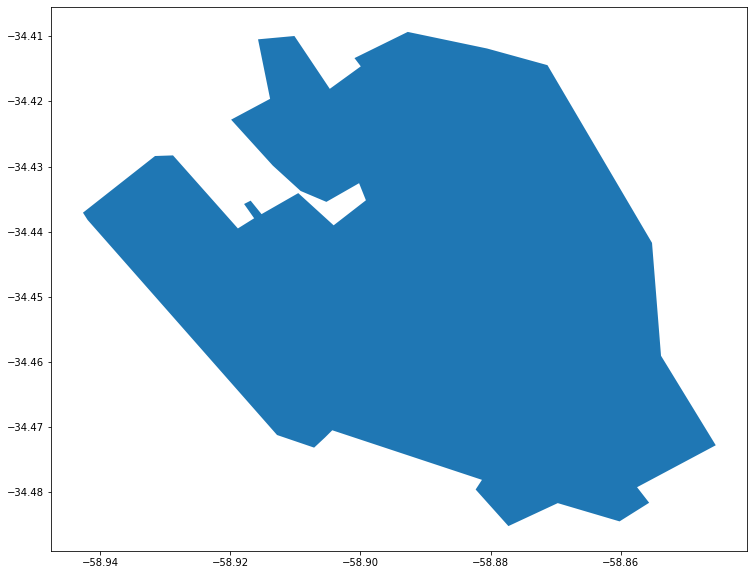

In [8]:
# GeoDataFrame(df, geometry='Coordinates')
zone = pd.DataFrame(
        {'shape': download["zone_shape"].unique()})

# We have to normalize the geographical framework
from shapely import wkt
zone['shape'] = zone['shape'].apply(wkt.loads)
geo_zone = gpd.GeoDataFrame(zone, geometry= "shape")
geo_zone.plot(figsize = (13,10));

In [9]:
# We get a GeoDataFrame
ticket_geo_points = gpd.GeoDataFrame(download[['order_id','ticket','ord_coord']], geometry = download['ord_coord'].apply(wkt.loads), crs="EPSG:4326")
del ticket_geo_points['ord_coord']
ticket_geo_points = ticket_geo_points[download['ticket'] > 0] 

In [ ]:
ticket_geo_points.head()

In [11]:
# Pag: https://www.youtube.com/watch?v=n6Ubiuo0UKA

# Versión con valores
from folium.plugins import HeatMap

# We center the map
boulder_coords = [-34.458771419491846, -58.91344957144817]

# We create the map in Folium
map2 = folium.Map(location = boulder_coords, zoom_start = 15)

### Gradient Colors to get to a Heatmap
data = download[['lat','lon','ticket']]
min_ticket = min(data['ticket']) 
max_ticket = max(data['ticket']) 


# Plot
mapdata = [[row[0],row[1],(row[2] - min_ticket)/(max_ticket - min_ticket)] for index, row in data.iterrows()]

colrGradient = {0.2: 'blue',
                0.3: 'cyan',
                0.4: 'green',
                0.6: 'lime',
                #0.8: 'yellow',
                #0.95: 'orange',
                1.0: 'red'}


HeatMap(mapdata, gradient = colrGradient).add_to(map2)

map2.save("output.html")
map2

## We build a fishgrid

In [12]:
# Source: https://gis.stackexchange.com/questions/269243/creating-polygon-grid-using-geopandas

from shapely.geometry import Polygon
points = gpd.GeoDataFrame(ticket_geo_points.iloc[:,2], geometry = ticket_geo_points['geometry'], crs="EPSG:4326")
xmin,ymin,xmax,ymax =  points.total_bounds
length = abs(ymax-ymin)/8
wide = abs(xmax-xmin)/8

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons}, crs="EPSG:4326")

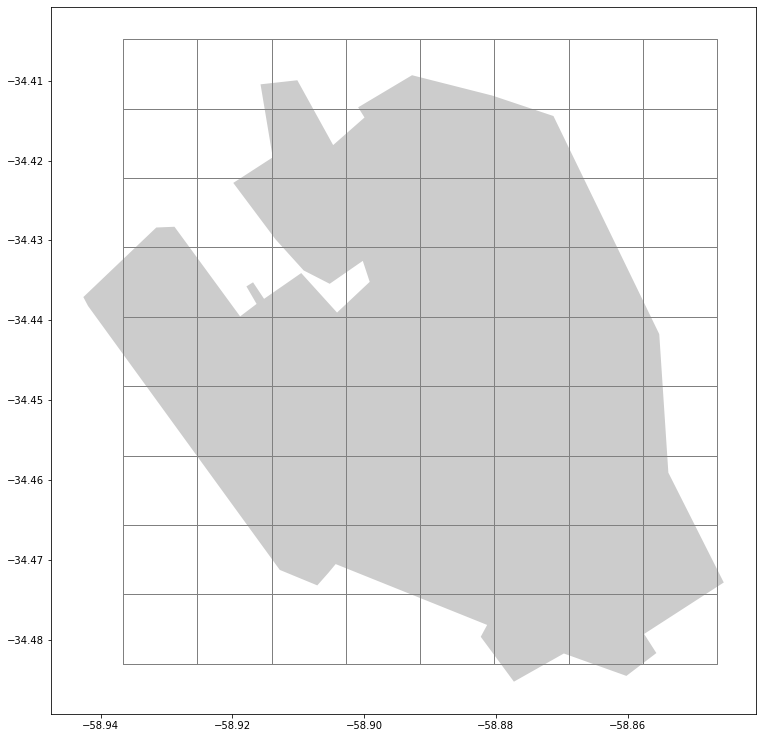

In [13]:
fig, ax = plt.subplots(figsize = (15,13))
geo_zone.plot(ax =ax, alpha = 0.4, color = "grey")
grid.plot(ax = ax,  facecolor="none", edgecolor='grey');

In [ ]:
poli_points = gpd.sjoin(ticket_geo_points, grid, how='right') # Con el inner join nos sacamos 2 puntos que cayeron afuera por redondeo de coordenadas

# Clean NaNs and unnecessary columns
poli_points.dropna(inplace =True)
del poli_points['index_left']

In [ ]:
# Remember we can not group by geometry!!
from shapely import wkt
poli_points['geo_string'] = poli_points.geometry.apply(lambda x: wkt.dumps(x,trim=False))
poli_points.head()

In [83]:
ticket_by_grid = agrup.agg({'ticket':['mean','std'],'order_id':'count'}).reset_index()
ticket_by_grid.columns = [' '.join(col).rstrip('_') for col in ticket_by_grid.columns.values] # Ponemos flat las columnas
ticket_by_grid['geometry'] =ticket_by_grid.iloc[:,0].apply(lambda x: wkt.loads(x))

ticket_by_grid = ticket_by_grid.iloc[:,1:]
ticket_by_grid['cv'] = round(ticket_by_grid['ticket std'] / abs(ticket_by_grid['ticket mean']),2)
ticket_by_grid['ticket std'] = round(ticket_by_grid['ticket std'],2)
ticket_by_grid['ticket mean'] = round(ticket_by_grid['ticket mean'],2)

In [ ]:
#We transform it into Dataframe
ticket_by_grid = gpd.GeoDataFrame(ticket_by_grid, geometry = ticket_by_grid['geometry'], crs="EPSG:4326")
ticket_by_grid.head()

In [91]:
# Count and eliminate NAs
# ticket_by_grid.isnull().sum()
ticket_by_grid.dropna(inplace = True)

In [ ]:
# https://jingwen-z.github.io/how-to-draw-a-map-with-folium-module-in-python/
# https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/

# We add colours into the map
import branca.colormap as cm
colormap_dept = cm.StepColormap(
    colors=['#00ae53', '#86dc76', '#daf8aa',
            '#ffe6a4', '#ff9a61', '#ee0028'],
    vmin=min(ticket_by_grid['ticket mean']),
    vmax=max(ticket_by_grid['ticket mean']),
    index=np.linspace(vmin,vmax,6))

# Map Center
boulder_coords = [-34.458771419491846, -58.91344957144817]

# We render the map
map3 = folium.Map(location = boulder_coords, zoom_start = 15)

style_function = lambda x: {
    'fillColor': colormap_dept(x['properties']['ticket mean']),
    'color': '',
    'weight': 0.0001,
    'fillOpacity': 0.4
}

folium.GeoJson(
    ticket_by_grid,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['ticket mean'],
        aliases=['ticket Promedio'],
        localize=False
    ),
    name='Community').add_to(map3)
map3.save("output2.html")
map3

## Another easy way to render points into geometry fastly

No handles with labels found to put in legend.


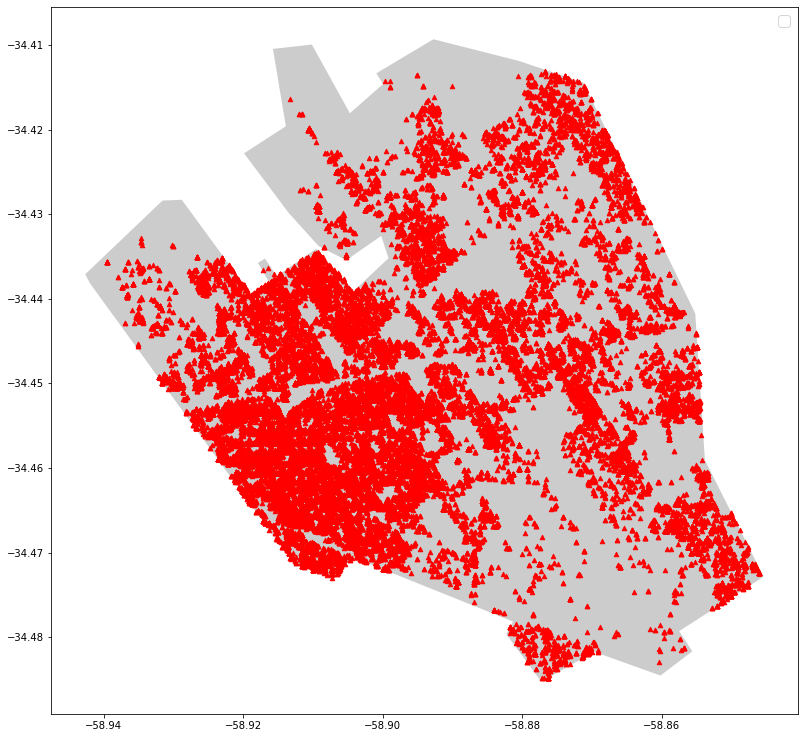

In [139]:
fig, ax = plt.subplots(figsize = (15,13))
geo_zone.plot(ax =ax, alpha = 0.4, color = "grey")
ticket_geo_points.plot(ax = ax, markersize = 20, color = "red", marker = "^")
plt.legend(prop = {'size':15});